<a href="https://colab.research.google.com/github/jpasamar19/TallerVirtual/blob/main/Taller-Docking/MolecularDocking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TALLER VIRTUAL INTERACTIVO: Descubriendo las principales áreas de la Bioinformática**
---
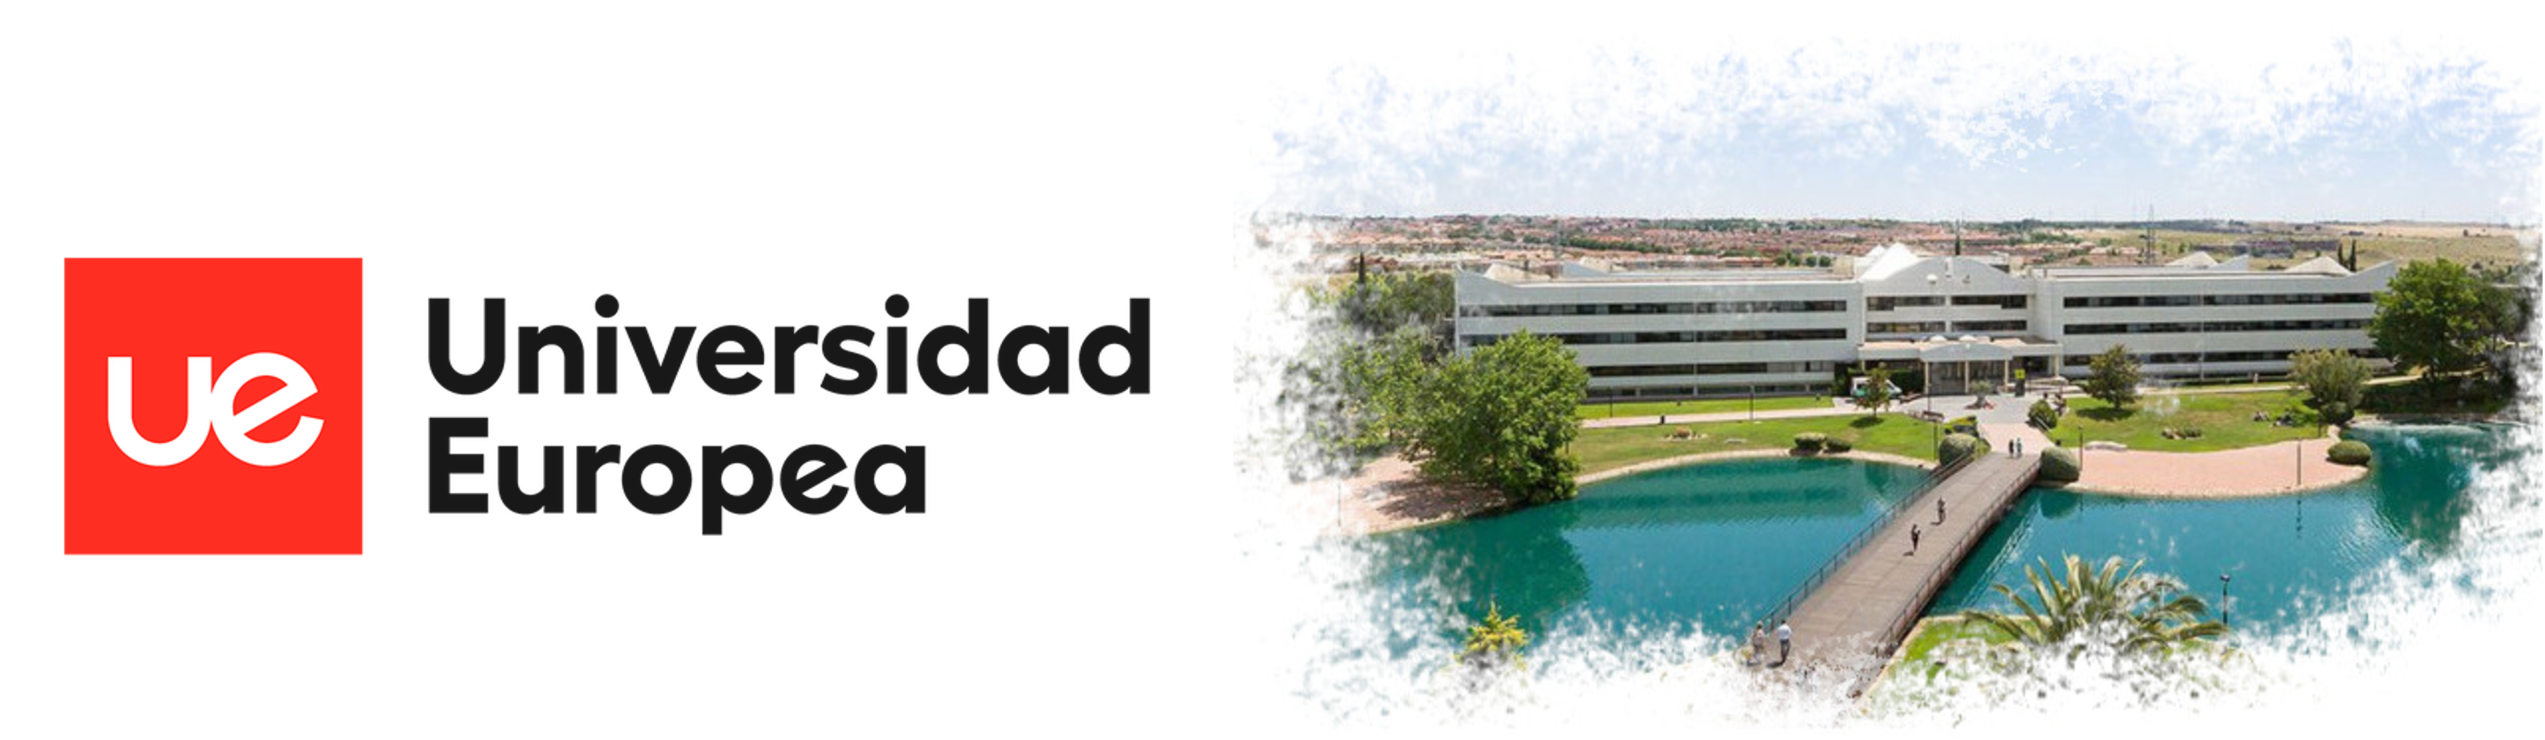

# **TALLER DE DOCKING**

El **acoplamiento molecular**, también conocido como **docking molecular**, es un proceso fundamental en la investigación farmacéutica y la bioinformática. Permite predecir cómo una molécula (llamada **ligando**) se une a una proteína o macromolécula (llamada **diana**) para formar un complejo estable. Imagina que estás buscando la cerradura perfecta para una llave específica: el acoplamiento molecular es como encontrar esa combinación precisa.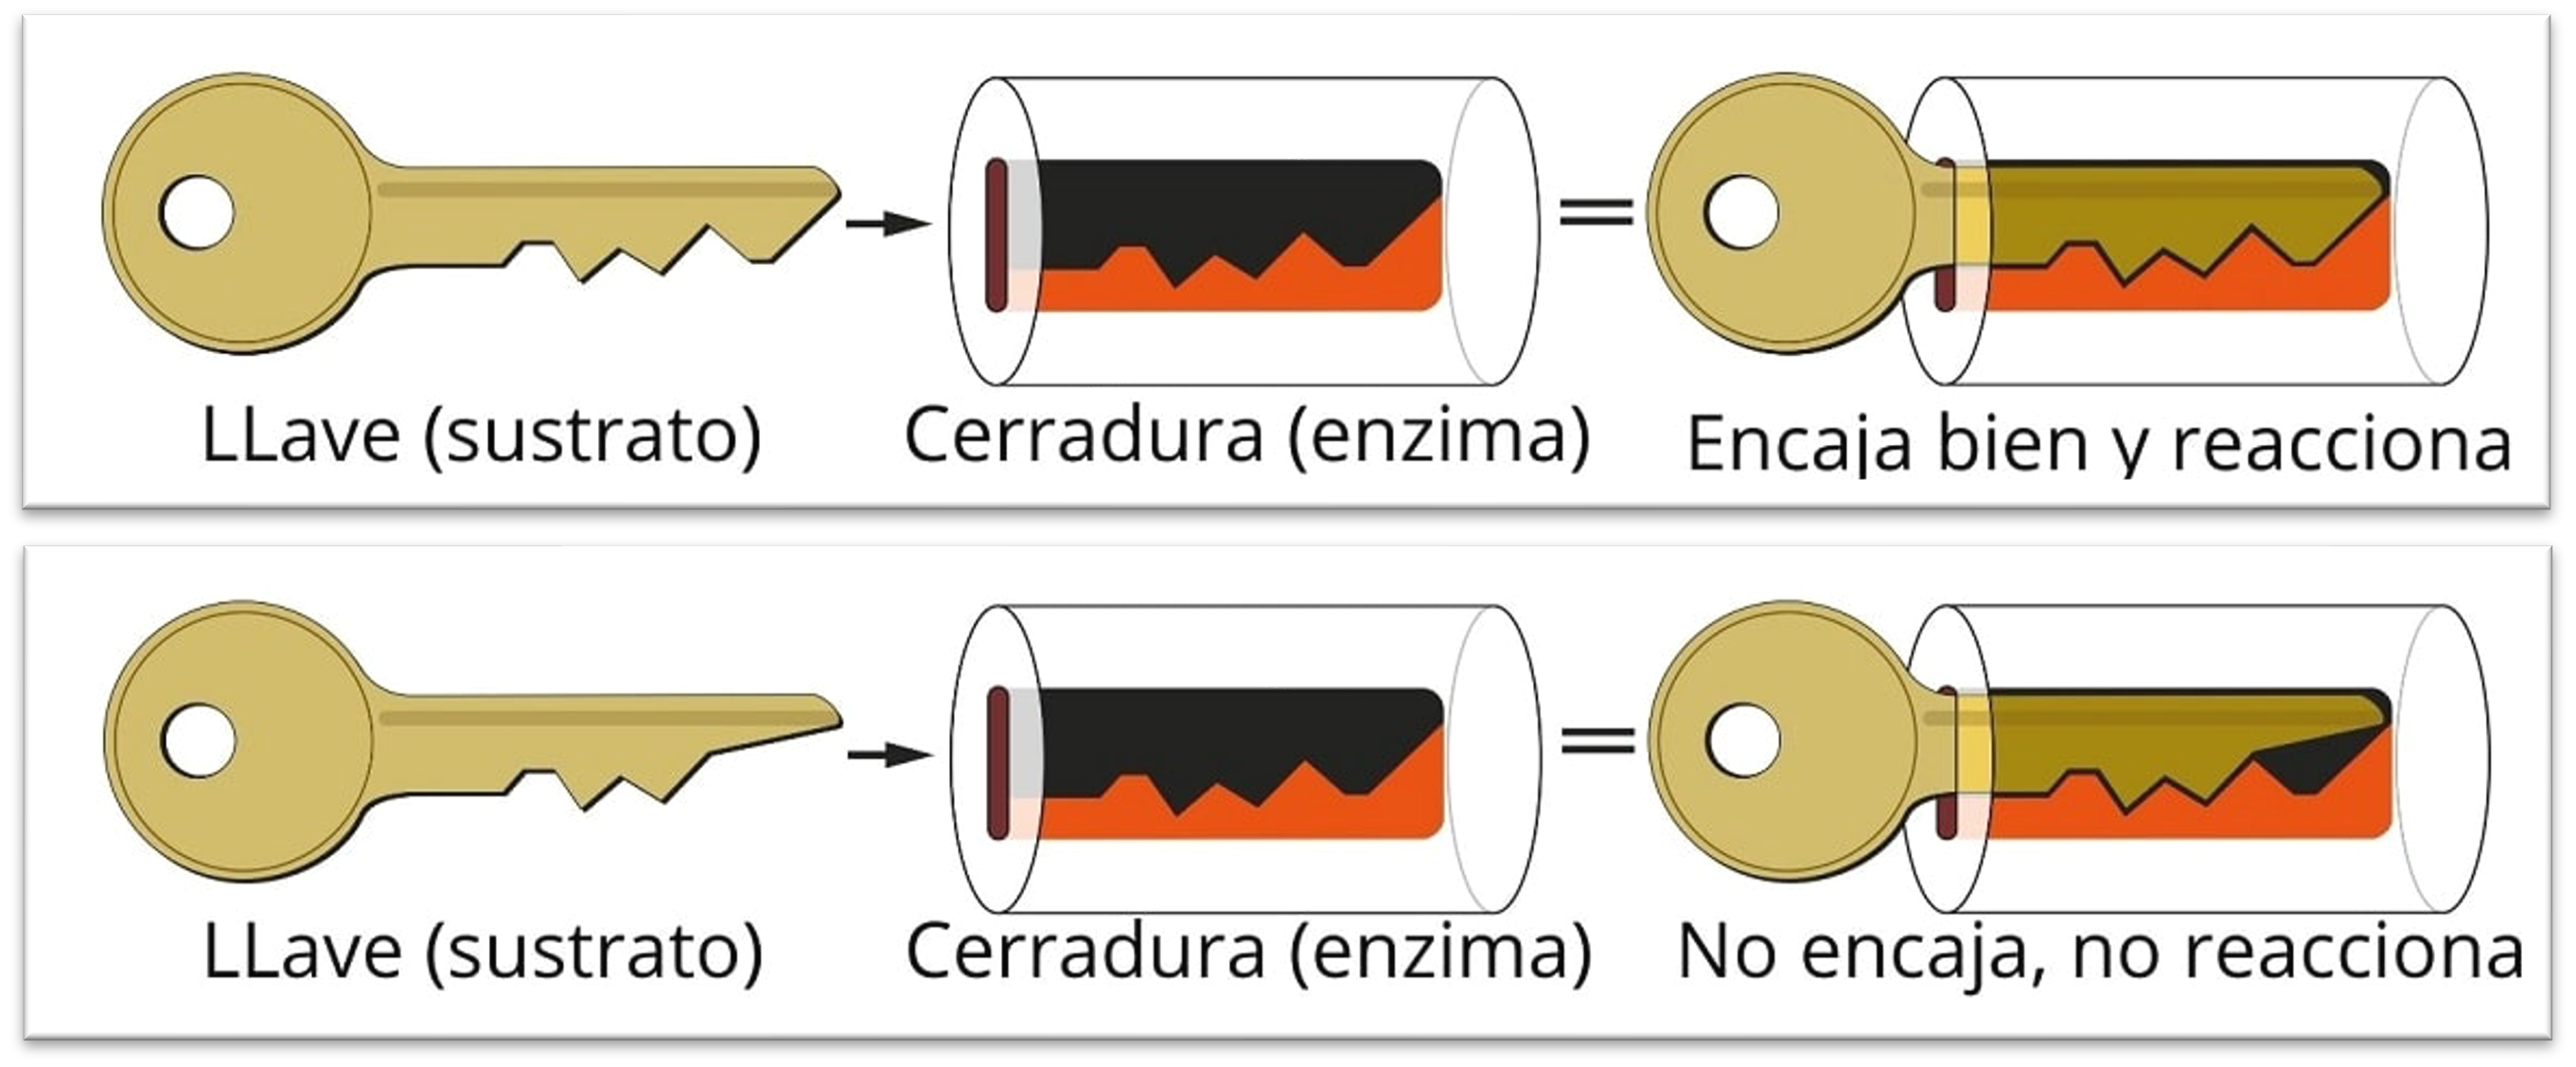

Aquí están los aspectos clave del acoplamiento molecular:

1. **Representación tridimensional**:
   - Tanto el ligando como la diana se representan en un espacio tridimensional.
   - El ligando puede ser un fármaco, una pequeña molécula o incluso un fragmento de ADN.
   - La diana suele ser una proteína, como una enzima o un receptor.

2. **Exploración de posiciones**:
   - El programa de acoplamiento evalúa diferentes posiciones y orientaciones del ligando en relación con la diana.
   - Busca la configuración más favorable en términos de energía y complementariedad.

3. **Cálculo de afinidad**:
   - Se calcula la energía de interacción entre el ligando y la diana.
   - Un valor negativo de energía indica una unión favorable.

4. **Resultados y predicciones**:
   - El acoplamiento molecular proporciona una puntuación (puntuación de acoplamiento) que refleja la calidad de la unión.
   - Los investigadores pueden predecir si un ligando se unirá fuertemente o débilmente la diana.

**¿Cómo se hace?**
1. **Preparación**: Se preparan las estructuras tridimensionales del ligando y la diana.
2. **Exploración**: El programa evalúa miles de posiciones y orientaciones.
3. **Cálculo de energía**: Se calcula la energía de unión.
4. **Resultados**: Se obtiene una puntuación de acoplamiento y se visualiza el complejo ligando-diana.



En resumen, el Docking es una herramienta poderosa que combina la Química Computacional, la Inteligencia Artificial y el Big Data para acelerar el descubrimiento de nuevos medicamentos y la comprensión de las interacciones moleculares en el cuerpo humano. ¡Es como resolver un rompecabezas a nivel atómico! 🧩🔬

---
---
## **1. INSTALACIÓN DE PROGRAMAS**

In [ ]:
# @title **1.1 Instalar paquetes y dependencias**
# @markdown Este proceso tarda entorno a **2 minutos.**

import sys
import time
import contextlib

with open('/content/labodock_install.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !rm -r /content/sample_data
        !wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_linux_x86_64 -O vina
        !chmod u+x vina

        !pip install py3Dmol==2.0.3
        !pip install rdkit-pypi==2022.9.5
        !pip install meeko==0.5.0
        !pip install spyrmsd
        !apt install plip
        !apt install openbabel
        end = time.time()
        # -- End installation --

print(f'+ Tiempo transcurrido para la instalación: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

In [ ]:
# @title **1.2. Importar módulos de Python**
# @markdown Esto importará los módulos de Python necesarios.

# Internal Modules
import os
import glob
import time
import shutil

# External modules
import py3Dmol
import plip

# Data-related
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Google Colab-related
from google.colab import drive, files
from tqdm.notebook import tqdm

# Docking-related
from rdkit import Chem, RDLogger
from rdkit.Chem import rdFMCS, AllChem, Draw
from spyrmsd import io, rmsd

# Binding interaction-related
from plip.exchange.report import BindingSiteReport
from plip.structure.preparation import PDBComplex

print(f'+ Completada la importación')

Job_name = 'UEM'   # @ param {type: 'string'}

invalid_chars = '^<>/\\{}[]~`$ '
assert Job_name, 'Do not leave this blank.'
assert not set(invalid_chars).intersection(Job_name), 'Disallowed characters.'

DIR = os.getcwd()
WRK_DIR = os.path.join(DIR, Job_name)
PRT_FLD = os.path.join(WRK_DIR, 'PROTEINA')
LIG_FLD = os.path.join(WRK_DIR, 'LIGANDO')
NTV_FLD = os.path.join(WRK_DIR, 'NATIVO')
DCK_FLD = os.path.join(WRK_DIR, 'DOCKING')
INT_FLD = os.path.join(WRK_DIR, 'INTERACCION')

folders = [WRK_DIR, PRT_FLD, LIG_FLD, NTV_FLD, DCK_FLD, INT_FLD]

for folder in folders:
    if os.path.exists(folder):
        print(f'+ La carpeta existe: {folder}')
    else:
        os.mkdir(folder)
        print(f'+ Carpeta creada: {folder}')

In [ ]:
# @title **1.3. Configurar utilidades**
# @markdown Esto crea importantes funciones y métodos personalizados para más adelante.

%alias vina /content/vina

#############################################
# Suppress Warnings

RDLogger.DisableLog('rdApp.warning')

#############################################
# Grid Box Calculation Methods

class GridBox:

    ranges = tuple[list[float], list[float], list[float]]
    coords = tuple[float, float, float]
    center_bxsize = tuple[tuple[float, float, float], tuple[float, float, float]]

    def __init__(self, inpt_file: str) -> None:
        self.inpt = open(inpt_file, 'r')
        self.data = self.inpt.read()
        self.cmol = Chem.MolFromPDBBlock(self.data)
        self.conf = self.cmol.GetConformer()
        self.ntom = self.cmol.GetNumAtoms()
        self.inpt.close()

    def update_gridbox(self, mol_block: str) -> None:
        self.cmol = Chem.MolFromPDBBlock(mol_block)
        self.conf = self.cmol.GetConformer()
        self.ntom = self.cmol.GetNumAtoms()

    def compute_coords(self) -> ranges:
        x_coord = [self.conf.GetAtomPosition(c).x for c in range(self.ntom)]
        y_coord = [self.conf.GetAtomPosition(c).y for c in range(self.ntom)]
        z_coord = [self.conf.GetAtomPosition(c).z for c in range(self.ntom)]
        return x_coord, y_coord, z_coord

    def compute_ranges(self) -> ranges:
        x, y, z = self.compute_coords()
        x_range = [min(x), max(x)]
        y_range = [min(y), max(y)]
        z_range = [min(z), max(z)]
        return x_range, y_range, z_range

    def compute_center(self, use_range: bool = True) -> coords:
        x, y, z = self.compute_ranges() if use_range else self.compute_coords()
        x_center = round(np.mean(x), 3)
        y_center = round(np.mean(y), 3)
        z_center = round(np.mean(z), 3)
        return x_center, y_center, z_center

    def generate_res_molblock(self, residues_list: list[str]) -> str:
        res_lines = [line for line in self.data.split('\n')
                     if line[22:26].lstrip() in residues_list
                     and 'END' not in line]
        res_block = '\n'.join(res_lines)
        return res_block

    def labox(self, scale: float = 2.0) -> coords:
        xr, yr, zr = self.compute_ranges()
        center = self.compute_center()
        bxsize = (round(abs(xr[0] - xr[1]) * scale, 3),
                  round(abs(yr[0] - yr[1]) * scale, 3),
                  round(abs(zr[0] - zr[1]) * scale, 3))
        return center, bxsize

    def eboxsize(self, gy_box_ratio: float = 0.23, modified: bool = False) -> center_bxsize:
        xc, yc, zc = self.compute_coords()
        center = self.compute_center(modified)
        distsq = [(x-center[0])**2 + (y-center[1])**2 + (z-center[2])**2
                  for x, y, z in zip(xc, yc, zc)]
        bxsize = (round(np.sqrt(sum(distsq) / len(xc)) / gy_box_ratio, 3),) * 3
        return center, bxsize

    def autodock_grid(self) -> center_bxsize:
        xr, yr, zr = self.compute_ranges()
        center = self.compute_center()
        bxsize = (22.5, 22.5, 22.5)
        return center, bxsize

    def defined_by_res(self, residue_number: str, scale: float = 1.25) -> center_bxsize:
        res_list = residue_number.replace(',', ' ').split()
        res_block = self.generate_res_molblock(res_list)
        self.update_gridbox(res_block)
        return self.labox(scale=scale)

#############################################
# RMSD Calculation Methods

class ComputeRMSD:

    def __init__(self) -> None:
        self.MCS_mol = None
        self.MCS_png = None

    def load_molecule(self, inpt_file: str, remove_Hs: bool = True) -> tuple:
        molecule = io.loadmol(inpt_file)
        molecule.strip() if remove_Hs else None
        name = os.path.basename(inpt_file).split('.')[0]
        coor = molecule.coordinates
        anum = molecule.atomicnums
        mtrx = molecule.adjacency_matrix
        cmol = Chem.MolFromPDBFile(inpt_file)
        return name, coor, anum, mtrx, cmol

    def mol_to_png(self, mol: object) -> object:
        legend = 'Maximum Common Substructure'
        png = Draw.MolToImage(mol, legend=legend)
        return png

    def find_MCS(self, ref: tuple, lig: tuple) -> object:
        if self.MCS_mol is None:
            MCS_obj = rdFMCS.FindMCS([ref[4], lig[4]])
            MCS_mol = Chem.MolFromSmarts(MCS_obj.smartsString)
            MCS_png = self.mol_to_png(MCS_mol)
            self.MCS_mol = MCS_mol
            self.MCS_png = MCS_png
        return self.MCS_mol

    def hung_RMSD(self, ref: tuple, lig: tuple) -> float:
        try:
            hRMSD = round(rmsd.hrmsd(ref[1], lig[1], ref[2], lig[2]), 3)
        except:
            hRMSD = 'ERROR'
        return hRMSD

    def symm_RMSD(self, ref: tuple, lig: tuple, minimise: bool = False) -> float:
        try:
            sRMSD = round(rmsd.symmrmsd(ref[1], lig[1], ref[2], lig[2], ref[3], lig[3], minimize=minimise), 3)
        except:
            sRMSD = 'ERROR'
        return sRMSD

    def labo_RMSD(self, ref: tuple, lig: tuple) -> float:
        mol_substr = self.find_MCS(ref, lig)
        ref_substr = ref[4].GetSubstructMatch(mol_substr)
        lig_substr = lig[4].GetSubstructMatch(mol_substr)

        distsq = []
        for ref_atom, lig_atom in zip(ref_substr, lig_substr):
            ref_pos = ref[4].GetConformer().GetAtomPosition(ref_atom)
            lig_pos = lig[4].GetConformer().GetAtomPosition(lig_atom)
            ref_coord = np.array((ref_pos.x, ref_pos.y, ref_pos.z))
            lig_coord = np.array((lig_pos.x, lig_pos.y, lig_pos.z))
            coo_dist = np.linalg.norm(ref_coord - lig_coord)
            distsq.append(coo_dist ** 2)

        try:
            lRMSD = round(np.sqrt(sum(distsq)/len(distsq)), 3)
        except:
            lRMSD = 'ERROR'
        return lRMSD

    def rmsd_report(self,
                    ref: tuple,
                    lig: tuple,
                    lRMSD: bool = True,
                    hRMSD: bool = True,
                    sRMSD: bool = True
                    ) -> dict[str: list[float]]:
        report = {}
        report['NAME'] = [lig[0]]
        report['LABO_RMSD'] = [self.labo_RMSD(ref, lig)] if lRMSD else None
        report['HUNG_RMSD'] = [self.hung_RMSD(ref, lig)] if hRMSD else None
        report['SYMM_RMSD'] = [self.symm_RMSD(ref, lig)] if sRMSD else None
        report = {k: v for k, v in report.items() if v is not None}
        return report

#############################################
# AA Consntant and Bond Colour Dictionary

# Kyte and Doolittle Hydropathy Scale (1982)
AA_HB = {'ALA':  1.8, 'ARG': -4.5, 'ASN': -3.5, 'ASP': -3.5, 'CYS':  2.5,
         'GLN': -3.5, 'GLU': -3.5, 'GLY': -0.4, 'HIS': -3.2, 'ILE':  4.5,
         'LEU':  3.8, 'LYS': -3.9, 'MET':  1.9, 'PHE':  2.8, 'PRO': -1.6,
         'SER': -0.8, 'THR': -0.7, 'TRP': -0.9, 'TYR': -1.3, 'VAL':  4.2}

# University of Calgary PI Scale
AA_PI = {'ALA':  6.0, 'ARG': 10.76, 'ASN': 5.41, 'ASP': 2.77, 'CYS': 5.07,
         'GLN': 5.65, 'GLU':  3.22, 'GLY': 5.97, 'HIS': 7.59, 'ILE': 6.02,
         'LEU': 5.98, 'LYS':  9.74, 'MET': 5.74, 'PHE': 5.48, 'PRO':  6.3,
         'SEC': 5.68, 'SER':  5.68, 'THR':  5.6, 'TRP': 5.89, 'TYR': 5.66,
         'VAL': 5.96}

BOND_COL = {'HYDROPHOBIC': ['0x59e382', 'GREEN'],
            'HBOND': ['0x59bee3', 'LIGHT BLUE'],
            'WATERBRIDGE': ['0x4c4cff', 'BLUE'],
            'SALTBRIDGE': ['0xefd033', 'YELLOW'],
            'PISTACKING': ['0xb559e3', 'PURPLE'],
            'PICATION': ['0xe359d8', 'VIOLET'],
            'HALOGEN': ['0x59bee3', 'LIGHT BLUE'],
            'METAL':['0xe35959', 'ORANGE']}

#############################################
# AA-to-Colour Converter Function

def sequential_gradient(value: float,
                        min_value: float,
                        max_value: float,
                        targ_colour: str = '00ff00',
                        interpolation: float = 0.0
                        ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)

    rgb = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))
    r = int(255 - (255 - rgb[0]) * (1 - interpolation) * norm_val)
    g = int(255 - (255 - rgb[1]) * (1 - interpolation) * norm_val)
    b = int(255 - (255 - rgb[2]) * (1 - interpolation) * norm_val)

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def diverging_gradient(value: float,
                       min_value: float,
                       max_value: float,
                       base_colour: str = 'ff0000',
                       targ_colour: str = '0000ff',
                       interpolation: float = 0.3
                       ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)

    white = (255, 255, 255)
    rgb_A = tuple(int(base_colour[d:d+2], 16) for d in (0, 2, 4))
    rgb_B = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))

    if norm_val < 0.5 - interpolation / 2:
        factor = norm_val / (0.5 - interpolation / 2)
        r = int(rgb_A[0] + (white[0] - rgb_A[0]) * factor)
        g = int(rgb_A[1] + (white[1] - rgb_A[1]) * factor)
        b = int(rgb_A[2] + (white[2] - rgb_A[2]) * factor)
    elif norm_val > 0.5 + interpolation / 2:
        factor = (norm_val - 0.5 - interpolation / 2) / (0.5 - interpolation / 2)
        r = int(white[0] + (rgb_B[0] - white[0]) * factor)
        g = int(white[1] + (rgb_B[1] - white[1]) * factor)
        b = int(white[2] + (rgb_B[2] - white[2]) * factor)
    else:
        r, g, b = white

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def a2c_converter(aa_map: dict, grad_func: 'function') -> dict:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())
    aa_dict = {aa: grad_func(value, min_value, max_value)
               for aa, value in aa_map.items()}
    return aa_dict

#############################################
# Built-in Styling Function

def builtin_style(style: str, opacity: float = 1.0) -> dict:
    match style:
        case _ if any(kw in style for kw in ('Carbon', 'chain', 'ssJmol', 'ssPyMol')):
            style_dict = {'colorscheme': style}
        case 'hydrophobicity':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_HB, sequential_gradient)}}
        case 'isoelectric points':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_PI, diverging_gradient)}}
        case 'b factor':
            style_dict = {'colorscheme': {
                'prop': 'b', 'gradient': 'rwb', 'min': 90, 'max': 50}}
        case _:
            style_dict = {'color': style}

    style_dict.update({'opacity': opacity, 'singleBonds': False})
    return style_dict

#############################################
# Built-in Colour Scale Function

def colour_scale(aa_map: dict, grad_func: 'function') -> None:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())

    linear_values = np.linspace(min_value, max_value, 100)
    colours = [grad_func(value, min_value, max_value)
               for value in linear_values]

    fig, ax = plt.subplots(figsize=(4.85, 0.25))
    norm_value = plt.Normalize(min_value, max_value)
    colour_map = plt.cm.colors.ListedColormap(colours)
    scalar_map = plt.cm.ScalarMappable(norm_value, colour_map)
    scalar_map.set_array([])

    cscale = plt.colorbar(scalar_map, ax, orientation='horizontal')
    cscale.set_ticks([min_value, max_value])

def show_cscale(rept_info: dict, surf_info: dict) -> None:

    def cs_selector() -> str:
        if any(surf_info):
            style = [*surf_info.values()][0]
        elif any(rept_info):
            style = [*rept_info.values()][0]
        else:
            style = None
        return style

    def cs_display(style: str):
        if style == 'hydrophobicity':
            label_title(style, 'Less', 'More')
            colour_scale(AA_HB, sequential_gradient)
        elif style == 'isoelectric points':
            label_title(style, 'Acid', 'Base')
            colour_scale(AA_PI, diverging_gradient)
        else:
            pass

    def label_title(text: str, min: str, max: str) -> None:
        print(f'-' * 55)
        print(f'{min}{text.upper():^47}{max}')
        print(f'-' * 55)

    cs_display(cs_selector())

#############################################
# Other Functions

def extract_config(inpt_file: str) -> tuple:
    with open(inpt_file, 'r') as inpt:
        data = [line.split() for line in inpt.readlines()]
    center = (float(data[0][2]), float(data[1][2]), float(data[2][2]))
    bxsize = (float(data[4][2]), float(data[5][2]), float(data[6][2]))
    return center, bxsize

def interaction_dict(inpt_file: str, interactions: str = '', usage: str = 'view' or 'lbsp') -> dict:

    usg_map = {'lbsp': 0, 'view': 1}

    def filter_df(int_df: pd.DataFrame, interactions: list = []) -> pd.DataFrame:
        int_df = int_df[int_df['BOND'].isin(interactions)] if interactions else int_df
        return int_df

    def s2f_dict(item: dict) -> dict:
        return {key: tuple(float(val) for val in value[1:-1].split(','))
                for key, value in item.items()}

    def b2c_dict(item: dict) -> dict:
        return {key: BOND_COL[val][usg_map[usage]] for key, val in item.items()}

    intrxn = interactions.replace(',', ' ').split()
    inter_df = pd.read_csv(inpt_file)
    int_dict = filter_df(inter_df, intrxn).to_dict()
    int_dict['LIGCOO'] = s2f_dict(int_dict['LIGCOO'])
    int_dict['PROTCOO'] = s2f_dict(int_dict['PROTCOO'])
    int_dict['COLOR'] = b2c_dict(int_dict['BOND'])

    return int_dict

def find_midpoint(coords: list) -> tuple[float, float, float]:
    return tuple(round(coord, 3) for coord in np.mean(coords, axis=0))

#############################################
# LaboSpace Viewer

class LaboSpace:

    residue_style = {
        'stick':
         {'colorscheme': 'orangeCarbon', 'radius': 0.15}}
    residue_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 25, 'y': 25}}
    atom_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 10, 'y': 10}}

    def __init__(self, vw: int = 500, vh: int = 500) -> None:
        self.mview = py3Dmol.view(width=vw, height=vh)
        self.count = -1
        self.residues = []

    def read_moldata(self, inpt_file: str) -> str:
        inpt = open(inpt_file, 'r')
        data = inpt.read()
        inpt.close()
        return data

    def load_receptor(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data, 'pdb')
        self.count += 1
        return self

    def load_ligand(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data)
        self.count += 1
        return self

    def set_style(self,
                  show_represent: bool = True,
                  represent_type: str = 'cartoon',
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.setStyle(
                {'model': self.count},
                {represent_type: represent_style})
        else:
            self.mview.setStyle(
                {'model': self.count},
                {})
        return self

    def add_style(self,
                  show_represent: bool = True,
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.addStyle(
                {'model': self.count},
                represent_style)
        return self

    def add_residues(self,
                     show_residues: bool = True,
                     residue_number: str = ''
                     ) -> object:
        if show_residues and residue_number:
            res = residue_number.replace(',', ' ').split()
            self.residues.extend(list(set(res)))
            self.mview.addStyle(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_label)
        return self

    def add_surface(self,
                    show_surface: bool = True,
                    surface_type: str = 'SES',
                    surface_style: dict = {}
                    ) -> object:
        if show_surface:
            self.mview.addSurface(
                surface_type,
                surface_style,
                {'model': self.count})
        return self

    def add_gridbox(self,
                    show_gridbox: bool,
                    center: list[float],
                    bxsize: list[float]
                    ) -> object:
        if show_gridbox:
            bxi, byi, bzi = center
            bxf, byf, bzf = bxsize
            self.mview.addBox({
                'center': {'x': bxi, 'y': byi, 'z': bzi},
                'dimensions': {'w': bxf, 'h': byf, 'd': bzf},
                'color': 'skyBlue',
                'opacity': 0.6})
            self.mview.addLabel(
                f'center: {bxi:>8}, {byi:>8}, {bzi:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': 0}})
            self.mview.addLabel(
                f'bxsize: {bxf:>8}, {byf:>8}, {bzf:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': -20}})
        return self

    def add_interaction(self,
                        interaction_file: str,
                        show_interaction: bool = True,
                        select_interaction: list = []
                        ) -> object:
        if show_interaction:
            int_dict = interaction_dict(interaction_file, select_interaction, 'lbsp')
            dist = int_dict['DIST'].values()
            bond = int_dict['BOND'].values()
            resn = int_dict['RESNR'].values()
            ligcoo = int_dict['LIGCOO'].values()
            prtcoo = int_dict['PROTCOO'].values()
            color = int_dict['COLOR'].values()

            int_res = list(set(resn) - set(self.residues))
            self.residues.extend(int_res)
            self.mview.addStyle(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_label)

            for dis, col, lig, prt in zip(dist, color, ligcoo, prtcoo):
                mid = find_midpoint([lig, prt])
                self.mview.addCylinder(
                    {'start': {'x': lig[0], 'y': lig[1], 'z': lig[2]},
                     'end': {'x': prt[0], 'y': prt[1], 'z': prt[2]},
                     'radius': 0.05,
                     'fromCap': 1,
                     'toCap': 1,
                     'color': col,
                     'dashed': True})
                self.mview.addLabel(
                    str(dis) + ' Å',
                    {'position': {'x': mid[0], 'y': mid[1], 'z': mid[2]},
                     'alignment': 'bottomLeft',
                     'inFront': False,
                     'backgroundColor': col,
                     'fontSize': 10,
                     'screenOffset': {'x': 10, 'y': 10}})
        return self

    def label_atoms(self, show_label: bool = False) -> object:
        # WARNING: Avoid applying on protein !!!
        if show_label:
            self.mview.addPropertyLabels(
                'atom',
                {'model': self.count},
                self.atom_label)
        return self

    def view_space(self,
                   zoom_model: int = -1,
                   slab_view: bool = False,
                   slab_model: int = -1,
                   background_colour: str = '0xFFFFFF'
                   ) -> None:
        self.mview.setBackgroundColor(background_colour)
        self.mview.setProjection('orthographic')
        self.mview.zoomTo({'model': zoom_model})
        self.mview.fitSlab({'model': slab_model}) if slab_view else None
        self.mview.show()

print(f'+ Métodos y funciones construidos exitosamente')

---
---
## **2. PREPARACIÓN DEL RECEPTOR (CICLOOXIGENASA)**

In [ ]:
# @title **2.1. Descargar la estructura de la proteína**


Accession_ID = '4PH9' # @ param {type: 'string'}

PDB_pdb = Accession_ID.upper() + '.pdb'
PDB_pdb_pFile = os.path.join(PRT_FLD, PDB_pdb)
Accession_ID_url = 'http://files.rcsb.org/download/' + PDB_pdb

!wget {Accession_ID_url} -O {PDB_pdb_pFile} -q
print(f'+ PDB Descargado: {PDB_pdb} > Carpeta PROTEINA')
print(f'+ Enlace a base de datos RCSB PDB: https://www.rcsb.org/structure/{Accession_ID}')

In [ ]:
# @title **2.2. Limpiar la estructura de las proteínas y extraer las subunidades.**
# @markdown + Esto genera una estructura proteica **limpia** que contiene todas las subunidades.

# @markdown + Las subunidades luego se extraen en archivos **`pdb`** individuales.



def oupt_parse(inpt_file: str) -> tuple:
    name = os.path.basename(inpt_file).split('.')[0]
    path = os.path.dirname(inpt_file)
    dirn = os.path.basename(path)
    return name, dirn, path

def ter_line(asn: str, resn: str, chid: str, resi: str) -> str:
    return f'TER   {asn}      {resn} {chid}{resi:>4} {" "*54}\n'

def extract_entity(inpt_file: str, oupt_file: str, keywords: list) -> None:
    oupt_name, oupt_dirn, oupt_path = oupt_parse(oupt_file)
    extract = []
    headers = ['ATOM', 'HETATM']
    with open(inpt_file, 'r') as inpt:
        for line in inpt:
            record = line.split()[0]
            if all(keyword in line for keyword in keywords) and \
               any(header in record for header in headers):
                extract.append(line)

    assert extract, 'Expected \'keywords\' in PDB lines; found 0 lines'

    with open(oupt_file, 'w') as oupt:
        for line in extract:
            oupt.write(line)
    print(f'+ Proteína extraída: {oupt_name}.pdb > {oupt_dirn} folder')

def extract_chains(inpt_file: str) -> None:
    inpt_name, oupt_dirn, oupt_path = oupt_parse(inpt_file)
    with open(inpt_file, 'r') as inpt:
        data = inpt.readlines()

    chid = sorted(set(line[21:22] for line in data))
    chid_leng = len(chid)
    chid_list = ', '.join(chid)
    print(f'+ Cadenas detectadas: {chid_leng} ({chid_list})')

    for id in chid:
        oupt_name = inpt_name + '_' + id
        oupt_file = os.path.join(oupt_path, oupt_name + '.pdb')
        with open(oupt_file, 'w') as oupt:
            for line in data:
                if line[21:22] in id:
                    oupt.write(line)
                    asn = f'{int(line[6:11])+1:>5}'
                    resn = line[17:20]
                    resi = line[22:26]
            oupt.write(ter_line(asn, resn, id, resi))
            oupt.write('END')
        print(f'+ Cadena extraída: {oupt_name}.pdb > {oupt_dirn} folder')

PDB_prot = Accession_ID + '_prot'
PDB_prot_pdb = PDB_prot + '.pdb'
PDB_prot_pdb_pFile = os.path.join(PRT_FLD, PDB_prot_pdb)

extract_entity(PDB_pdb_pFile, PDB_prot_pdb_pFile, ['ATOM'])
extract_chains(PDB_prot_pdb_pFile)

In [ ]:
# @title **2.3. Visualización de la estructura de la proteína en 3D**

Cadena = 'Entera' # @param ['A','B','Entera']
if Cadena == 'A':
  Cadena = '_A'
elif Cadena == 'B':
  Cadena = '_B'
else:
  Cadena = ''
View = Accession_ID+'_prot'+Cadena # @ param {type: 'string'}
Tipo_de_representacion='cartoon' # @param ['cartoon', 'cross', 'line', 'sphere', 'stick']
Representation_type=Tipo_de_representacion
Representation_style = 'whiteCarbon' # @ param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Opacidad=1 # @param {type: 'slider', min:0, max:1, step:0.1}
Representation_opacity=Opacidad
Residue_number = '' # @ param {type: 'string'}
Mostrar_superficie = False # @param {type: 'boolean'}
Surface_type = 'SAS' # @ param ['VDW', 'SAS', 'SES', 'MS']
Surface_style = 'isoelectric points' # @ param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Opacidad_de_la_superficie = 1 # @param {type: 'slider', min:0, max:1, step:0.1}
Surface_opacity = Opacidad_de_la_superficie
Show_representation = True # @ param {type: 'boolean'}
Show_residue = False # @ param {type: 'boolean'}
Show_surface = Mostrar_superficie

PROT_view_pFile = os.path.join(PRT_FLD, View + '.pdb')

LBSP = LaboSpace(960, 640)
LBSP.load_receptor(PROT_view_pFile)\
    .set_style(
        show_represent=Show_representation,
        represent_type=Representation_type,
        represent_style=builtin_style(
            style=Representation_style,
            opacity=Representation_opacity))\
    .add_residues(
        show_residues=Show_residue,
        residue_number=Residue_number)\
    .add_surface(
        show_surface=Show_surface,
        surface_type=Surface_type,
        surface_style=builtin_style(
            style=Surface_style,
            opacity=Surface_opacity))
LBSP.view_space()

show_cscale(
    {Show_representation: Representation_style},
    {Show_surface: Surface_style})

In [ ]:
# @title **2.4. Parametrizar el receptor con cargas de Gasteiger**
# @markdown Esto genera un archivo **`proteina.pdbqt`** después de:
# @markdown + Adición de carga parcial de Gasteiger.
# @markdown + Adición de hidrógenos polares.
# @markdown + Eliminación de hidrógenos no polares.

chain='A'
Target_protein = Accession_ID+'_prot_'+chain # @ param {type: 'string'}

PROT_pdb = Target_protein + '.pdb'
PROT_pdbqt = Target_protein + '.pdbqt'
PROT_pdb_pFile = os.path.join(PRT_FLD, PROT_pdb)
PROT_pdb_dFile = os.path.join(DCK_FLD, PROT_pdb)
PROT_pdbqt_dFile = os.path.join(DCK_FLD, PROT_pdbqt)

!obabel {PROT_pdb_pFile} -xr -O {PROT_pdbqt_dFile} -h --partialcharge gasteiger > /dev/null 2>&1
!mk_prepare_receptor.py --pdbqt {PROT_pdbqt_dFile} -o {PROT_pdbqt_dFile} --skip_gpf > /dev/null 2>&1
print(f'+ Parametrización: {PROT_pdb} > {PROT_pdbqt}')

shutil.copy(PROT_pdb_pFile, PROT_pdb_dFile)
print(f'+ {PROT_pdbqt} > Carpeta DOCKING')
print(f'+ {PROT_pdb} > Carpeta DOCKING')

---
---
## **3. PREPARACIÓN DE LOS LIGANDOS (MEDICAMENTOS)**

In [ ]:
# @title **3.1. Identificación del sitio de unión de los medicamentos**
# @markdown En la estructura de la proteína se encuentra el ibuprofeno que utilizaremos como punto de partida para
# @markdown probar el resto de medicamentos.


Keyword = 'IBP' # @ param {type: 'string'}

def get_molblock(keyword: str) -> str:
    url_path = 'http://files.rcsb.org/ligands/download/' + keyword + '_model.sdf'
    sdf_file = os.path.join(NTV_FLD, keyword + '.sdf')
    os.system(f'wget {url_path} -O {sdf_file} -q')
    molblock = [mol for mol in  Chem.SDMolSupplier(sdf_file) if mol is not None][0]
    os.remove(sdf_file)
    return molblock

def correct_bond_order(inpt_list: list, temp: Chem.rdchem.Mol) -> None:
    for inpt_file in inpt_list:
        targ = AllChem.MolFromPDBFile(inpt_file)
        cmol = AllChem.AssignBondOrdersFromTemplate(temp, targ)
        pdbb = Chem.MolToPDBBlock(cmol, flavor=4)
        with open(inpt_file, 'w') as oupt:
            oupt.write(pdbb)

true_id = Keyword[-3:] if len(Keyword) > 3 else Keyword
print(f'+ RCSB PDB link: https://www.rcsb.org/ligand/{true_id}')

ntv_pdb = Keyword.upper() + '.pdb'
ntv_pdb_nFile = os.path.join(NTV_FLD, ntv_pdb)
extract_entity(PDB_pdb_pFile, ntv_pdb_nFile, [Keyword, 'HETATM'])
extract_chains(ntv_pdb_nFile)

ntv_nFiles = sorted(glob.glob(NTV_FLD + '/' + Keyword + '_*.pdb'))
ntv_smiles = get_molblock(true_id)
correct_bond_order(ntv_nFiles, ntv_smiles)

In [ ]:
# @title **3.2. Generación de la estructura de los medicamentos de interés**

Force_field = 'UFF' # @ param ['GAFF', 'Ghemical', 'MMFF94', 'MMFF94s', 'UFF']
Convergence_criteria = '0.00001' # @ param ['0.1', '0.01','0.001', '0.0001', '0.00001', '0.000001', '0.0000001']
Maximum_steps = 10000 # @ param {type: 'slider', min:1000, max:100000, step:1000}


def check_convergence(log_file: str) -> None:
    with open(log_file, 'r') as inpt:
        data = inpt.read()
    if 'CONVERGED' in data:
        verb = 'ha'
        step = data.split('\n')[-4].split()[0]
        step_str = f'({step} steps)'
    else:
        verb = 'no ha'
        step_str = ''
    print(f'+ Gradiente conjugado {verb} convergido {step_str}')


#Ibuprofeno
ID = 'Ibuprofeno' # @ param {type: 'string'}
SMILES = 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O' # @ param {type: 'string'}

assert ID.strip(), 'Expected \'ID\'; found \'none\''
assert SMILES.strip(), 'Expected \'SMILES\'; found \'none\''

print(f'+ Ligando \'{ID}\' con \'{SMILES}\' listo')

LIG_ID = ID
LIG_sdf = LIG_ID + '.sdf'
LIG_obmin_log = LIG_ID + '_obmin.log'
LIG_sdf_lFile = os.path.join(LIG_FLD, LIG_sdf)
LIG_obmin_log_lFile = os.path.join(LIG_FLD, LIG_obmin_log)

!obabel -:{'"'+SMILES+'"'} -O {LIG_sdf_lFile} --title {LIG_ID} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > Carpeta LIGANDO')


#Aspirina
ID = 'Aspirina' # @ param {type: 'string'}
SMILES = 'CC(=O)OC1=CC=CC=C1C(=O)O' # @ param {type: 'string'}

assert ID.strip(), 'Expected \'ID\'; found \'none\''
assert SMILES.strip(), 'Expected \'SMILES\'; found \'none\''

print(f'+ Ligando \'{ID}\' con \'{SMILES}\' listo')

LIG_ID = ID
LIG_sdf = LIG_ID + '.sdf'
LIG_obmin_log = LIG_ID + '_obmin.log'
LIG_sdf_lFile = os.path.join(LIG_FLD, LIG_sdf)
LIG_obmin_log_lFile = os.path.join(LIG_FLD, LIG_obmin_log)

!obabel -:{'"'+SMILES+'"'} -O {LIG_sdf_lFile} --title {LIG_ID} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > Carpeta LIGANDO')

#Flurbiprofeno
ID = 'Flurbiprofeno' # @ param {type: 'string'}
SMILES = 'CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)O' # @ param {type: 'string'}

assert ID.strip(), 'Expected \'ID\'; found \'none\''
assert SMILES.strip(), 'Expected \'SMILES\'; found \'none\''

print(f'+ Ligando \'{ID}\' con \'{SMILES}\' listo')
LIG_ID = ID
LIG_sdf = LIG_ID + '.sdf'
LIG_obmin_log = LIG_ID + '_obmin.log'
LIG_sdf_lFile = os.path.join(LIG_FLD, LIG_sdf)
LIG_obmin_log_lFile = os.path.join(LIG_FLD, LIG_obmin_log)


!obabel -:{'"'+SMILES+'"'} -O {LIG_sdf_lFile} --title {LIG_ID} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > Carpeta LIGANDO')


#Naproxeno
ID = 'Naproxeno' # @ param {type: 'string'}
SMILES = 'CC(C1=CC2=C(C=C1)C=C(C=C2)OC)C(=O)O' # @ param {type: 'string'}

assert ID.strip(), 'Expected \'ID\'; found \'none\''
assert SMILES.strip(), 'Expected \'SMILES\'; found \'none\''

print(f'+ Ligando \'{ID}\' con \'{SMILES}\' listo')

LIG_ID = ID
LIG_sdf = LIG_ID + '.sdf'
LIG_obmin_log = LIG_ID + '_obmin.log'
LIG_sdf_lFile = os.path.join(LIG_FLD, LIG_sdf)
LIG_obmin_log_lFile = os.path.join(LIG_FLD, LIG_obmin_log)

!obabel -:{'"'+SMILES+'"'} -O {LIG_sdf_lFile} --title {LIG_ID} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > Carpeta LIGANDO')


#Diclofenaco
ID = 'Diclofenaco' # @ param {type: 'string'}
SMILES = 'C1=CC=C(C(=C1)CC(=O)O)NC2=C(C=CC=C2Cl)Cl' # @ param {type: 'string'}

assert ID.strip(), 'Expected \'ID\'; found \'none\''
assert SMILES.strip(), 'Expected \'SMILES\'; found \'none\''

print(f'+ Ligando \'{ID}\' con \'{SMILES}\' listo')

LIG_ID = ID
LIG_sdf = LIG_ID + '.sdf'
LIG_obmin_log = LIG_ID + '_obmin.log'
LIG_sdf_lFile = os.path.join(LIG_FLD, LIG_sdf)
LIG_obmin_log_lFile = os.path.join(LIG_FLD, LIG_obmin_log)

#print(f'+ Selected {Force_field} for energy minimisation '
#      f'up to {Convergence_criteria} iteration difference or '
#      f'at most {Maximum_steps:,} steps')

!obabel -:{'"'+SMILES+'"'} -O {LIG_sdf_lFile} --title {LIG_ID} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > Carpeta LIGANDO')

In [ ]:
# @title **3.3. Visualización de la estructura en 3D de los ligandos**
# @markdown A continaución se visualizarán las estructuras en 3D de los medicamentos que se van a probar.

Medicamento='Ibuprofeno' # @param ['Ibuprofeno', 'Aspirina', 'Flurbiprofeno', 'Naproxeno','Diclofenaco']
View=Medicamento
Tipo_de_representacion='stick' # @param ['line', 'sphere', 'stick']
Representation_type=Tipo_de_representacion
Mostrar_etiqueta_atomos = True # @param {type: 'boolean'}
Show_atom_labels=Mostrar_etiqueta_atomos

LIG_view_lFile = os.path.join(LIG_FLD, View + '.sdf')

LBSP = LaboSpace(960, 640)
LBSP.load_ligand(LIG_view_lFile)\
    .set_style(
        show_represent=True,
        represent_type=Representation_type,
        represent_style={'colorScheme': 'lightGreyCarbon'})\
    .label_atoms(
        show_label=Show_atom_labels)
LBSP.view_space()

In [ ]:
# @title **2.4. Parametrizar los ligandos con cargas de Gasteiger**
# @markdown Esto genera un archivo **`medicamento.pdbqt`** (por ejemplo,
# @markdown ibuprofeno.pdbqt) después de:
# @markdown + Adición de carga parcial de Gasteiger.
# @markdown + Adición de hidrógenos polares.
# @markdown + Eliminación de hidrógenos no polares.

def pdbqt_add_chid(inpt_file: str) -> None:
    with open(inpt_file, 'r') as inpt:
        data = inpt.read()
    new_data = data.replace('  UNL  ', '  UNL A')
    with open(inpt_file, 'w') as oupt:
        oupt.write(new_data)

for ID in 'Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco':
  LIG_pdbqt = ID + '.pdbqt'
  LIG_dFLD2 = os.path.join(DCK_FLD, ID)
  LIG_pdbqt_dFFile = os.path.join(LIG_dFLD2, LIG_pdbqt)
  LIG_sdf_lFile= '/content/UEM/LIGANDO/'+ID+'.sdf'
  os.makedirs(LIG_dFLD2, exist_ok=True)
  !mk_prepare_ligand.py -i {LIG_sdf_lFile} -o {LIG_pdbqt_dFFile} > /dev/null 2>&1
  pdbqt_add_chid(LIG_pdbqt_dFFile)

  print(f'+ Parametrización: {ID}.sdf > {LIG_pdbqt}')
  print(f'+ {LIG_pdbqt} > Carpeta DOCKING')

---
---
## **4. Cálculo del acoplamiento ligando-receptor (_Docking_)**

In [ ]:
# @title **Definición de la caja de rejilla (_Grid box_) en el sitio de unión**

# @markdown La _grid box_ se refiere a una región tridimensional del espacio
# @markdown definida por sus límites en los ejes x, y, y z. Esta "box" delimita el área
# @markdown donde se buscarán las posibles posiciones y orientaciones de un ligando (por
# @markdown ejemplo, un fármaco) con respecto a una proteína (por ejemplo, la
# @markdown ciclooxigenasa). La "box" es esencial para reducir el espacio de búsqueda
# @markdown y hacer más eficiente el proceso de acoplamiento molecular, permitiendo así un
# @markdown análisis más rápido y específico de las interacciones ligando-receptor.

Residue_number = '' # @ param {type: 'string'}
Method = 'Manual-Mode' # @ param ['LaBOX', 'eBoxSize', 'eBoxSize-Mod', 'Autodock-Grid', 'Defined-by-Res', 'Manual-Mode']
Show_residues = False # @ param {type: 'boolean'}

# Manual Mode
X = 13.01 # @ param {type: 'string'}
Y = 23.49 # @ param {type: 'number'}
Z = 25.26 # @ param {type: 'number'}
Width = 22.50 # @ param {type: 'number'}
Height = 22.50 # @ param {type: 'number'}
Depth = 22.50 # @ param {type: 'number'}
Scale = 22.50 # @ param {type: 'number'}

LBSP = LaboSpace(960, 640)
LBSP_view = True

NTV_pdb_nFile='/content/UEM/NATIVO/IBP_A.pdb'

try:
    if Method == 'Defined-by-Res':
        GB = GridBox(PROT_pdb_dFile)
        center, bxsize = GB.defined_by_res(Residue_number)
    if Method == 'Manual-Mode':
        center = (X, Y, Z)
        bxsize = (round(Width, 3),
                  round(Height, 3),
                  round(Depth, 3))
except Exception as excp:
    print(f'+ {excp}')
    print(f'+ Error can be:\n'
           '  - Expected \'Residue_number\'; found \'none\'\n'
           '  - Expected \'protein PDB file\'; found \'none\'\n'
           '  - Due to atomic error in \'protein PDB file\'')
    LBSP_view = False
else:
    LBSP.load_receptor(PROT_pdb_dFile)\
        .set_style(
            show_represent=True,
            represent_type='cartoon',
            represent_style={'color': 'white'})\
        .add_residues(
            show_residues=Show_residues,
            residue_number=Residue_number)

try:
    if Method == 'LaBOX':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.labox()
    if Method == 'eBoxSize':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.eboxsize()
    if Method == 'eBoxSize-Mod':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.eboxsize(modified=True)
    if Method == 'Autodock-Grid':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.autodock_grid()
except Exception as excp:
    print(f'+ {excp}')
    print(f'+ Expected \'native ligand PDB file\'; found \'none\'')
    print(f'+ Upload file to \'{NTV_FLD}\' and run \'Select native ligand\' cell to load it.')
    LBSP_view = False
else:
    try:
        LBSP.load_ligand(NTV_pdb_nFile)\
            .set_style(
                show_represent=True,
                represent_type='stick',
                represent_style={'colorScheme': 'greyCarbon'})
    except:
        pass

if LBSP_view:
    LBSP.add_gridbox(show_gridbox=True, center=center, bxsize=bxsize)
    LBSP.view_space()

# Generate docking config file

cfg_name = 'config_file'
cfg_dFile = os.path.join(DCK_FLD, cfg_name)

with open(cfg_dFile, 'w') as cfg:
    cfg.write(f'center_x = {center[0]}\n')
    cfg.write(f'center_y = {center[1]}\n')
    cfg.write(f'center_z = {center[2]}\n')
    cfg.write(f'\n')
    cfg.write(f'size_x = {bxsize[0]}\n')
    cfg.write(f'size_y = {bxsize[1]}\n')
    cfg.write(f'size_z = {bxsize[2]}\n')

#print(f'+ {cfg_name} > DOCKING folder')
print('+ Grid guardada con éxito')

In [ ]:
# @title **Cálculo de la energía de unión**
# @markdown En este apartado calcularemos la energía de unión más baja para encontrar
# @markdown la mejor forma en la que se puede unirse el medicamento al receptor.

Exhaustiveness = '16' # @ param [4, 8, 16, 32, 64, 128, 256]
for ID in 'Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco':
  LIG_ID = ID
  LIG_dFLD = '/content/UEM/DOCKING/'+LIG_ID
  cpu_cores = os.cpu_count()
  LIG_oupt_log = LIG_ID + '_output.log'
  LIG_oupt_pdbqt = LIG_ID + '_output.pdbqt'
  LIG_oupt_log_dFFile = os.path.join(LIG_dFLD, LIG_oupt_log)
  LIG_oupt_pdbqt_dFFile = os.path.join(LIG_dFLD, LIG_oupt_pdbqt)
  LIG_pdbqt_dFFile = LIG_dFLD+'/'+ID+'.pdbqt'
  # -- Start docking --
  start = time.time()
  %vina --receptor {PROT_pdbqt_dFile} --ligand {LIG_pdbqt_dFFile} \
  --out {LIG_oupt_pdbqt_dFFile} --config {cfg_dFile} --cpu {cpu_cores} \
  --exhaustiveness {Exhaustiveness} --verbosity 2 | tee {LIG_oupt_log_dFFile}
  end = time.time()
  # -- End docking --

  print(f'')
  print(f'+ Docking completed')
  print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))
  print(f'+ {LIG_oupt_pdbqt} > DOCKING folder')

---
---
## **5. ANÁLISIS DE LOS RESULTADOS**

In [ ]:
# @title **Procesamiento de los archivos de salida del programa Vina**
# @markdown Esto genera **ligand_[n].pdb** para cada posición de unión predicha.
for ID in 'Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco':
  LIG_ID=ID
  LIG_dFLD = '/content/UEM/DOCKING/'+LIG_ID
  LIG_oupt_pdbqt = ID+'_output.pdbqt'
  LIG_dash_pdb = LIG_ID + '_.pdb'
  LIG_dash_pdb_dFFile = os.path.join(LIG_dFLD, LIG_dash_pdb)
  LIG_oupt_pdbqt_dFFile = os.path.join(LIG_dFLD, LIG_oupt_pdbqt)


  with open(LIG_oupt_pdbqt_dFFile, 'r') as oupt:
     data = oupt.read()
     pose = data.count('MODEL')

  !obabel {LIG_oupt_pdbqt_dFFile} -O {LIG_dash_pdb_dFFile} -m > /dev/null 2>&1
  print(f'+ {pose} {LIG_ID}_[n].pdb > Carpeta DOCKING/{LIG_ID}')

In [ ]:
# @title **Generar archivo PDB del complejo**
# @markdown En este paso se junta la ciclooxigenasa con cada una de las poses de ligandos acoplados para producir archivos individuales **cmpx.pdb**.

def generate_cmpx_pdb(inpt_prot: str, inpt_pose: str, oupt_cmpx: str) -> None:

    def write_line(line: str, keywords: list, oupt_file: str) -> None:
        header = line.split()[0]
        if header in keywords:
            oupt_file.write(line)

    def cmpx_writer() -> None:
        with open(oupt_cmpx, 'w') as oupt_file, \
             open(inpt_prot, 'r') as prot_file, \
             open(inpt_pose, 'r') as pose_file:
            for prot_line in prot_file:
                write_line(prot_line, prot_headers, oupt_file)
            for pose_line in pose_file:
                write_line(pose_line, pose_headers, oupt_file)

    prot_headers = ['ATOM', 'CONECT', 'TER']
    pose_headers = ['ATOM', 'CONECT', 'END']
    cmpx_writer()
for ID in 'Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco':
  LIG_ID=ID
  LIG_dFLD = '/content/UEM/DOCKING/'+LIG_ID
  LIG_oupt_pdbqt = ID+'_output.pdbqt'
  LIG_dash_pdb = LIG_ID + '_.pdb'
  LIG_dash_pdb_dFFile = os.path.join(LIG_dFLD, LIG_dash_pdb)
  LIG_oupt_pdbqt_dFFile = os.path.join(LIG_dFLD, LIG_oupt_pdbqt)
  LIG_iFLD = os.path.join(INT_FLD, LIG_ID)
  os.makedirs(LIG_iFLD, exist_ok=True)
  LIG_pdb_dFFiles = sorted(glob.glob(LIG_dFLD + '/*.pdb'))

  count = 0
  for pose_file in tqdm(LIG_pdb_dFFiles):
    pose_name = os.path.basename(pose_file).split('.')[0]
    cmpx_pdb = pose_name + '_cmpx.pdb'
    cmpx_pdb_iFile = os.path.join(LIG_iFLD, cmpx_pdb)
    generate_cmpx_pdb(PROT_pdb_dFile, pose_file, cmpx_pdb_iFile)
    count += 1

  print(f'+ {count} {LIG_ID}_[n]_cmpx.pdb > INTERACTION folder')

In [ ]:
# @title **Procesamiento de las interacciones**
# @markdown En esta etapa se genera un **interpt.csv** que contiene todas las interacciones de unión detectadas para cada complejo cmpx.pdb. \


def interaction_profiler(inpt_cmpx: str, oupt_csv: str) -> None:

    int_bonds = ['HYDROPHOBIC', 'HBOND', 'WATERBRIDGE', 'SALTBRIDGE',
                 'PISTACKING', 'PICATION', 'HALOGEN', 'METAL']

    def BSR(inpt_cmpx: str) -> object:
        cmpx_mol = PDBComplex()
        cmpx_mol.load_pdb(inpt_cmpx)
        cmpx_lig = [lig for lig in cmpx_mol.ligands if lig.hetid == 'UNL'][0]
        cmpx_mol.characterize_complex(cmpx_lig)
        cmpx_int = cmpx_mol.interaction_sets['UNL:A:1']
        cmpx_rpt = BindingSiteReport(cmpx_int)
        return cmpx_rpt

    def BSR_feat(bsr: object) -> list:
        return [list(getattr(bsr, bond.lower() + '_features')) + ['BOND']
                for bond in int_bonds]

    def BSR_info(bsr: object) -> list:
        return [[list(info) + [bond] for info in getattr(bsr, bond.lower() + '_info')]
                for bond in int_bonds]

    def replace_column(df: pd.DataFrame, col_A: str, cols: list) -> pd.DataFrame:
        for col in cols:
            if col in df.columns:
                df[col_A] = df[col_A].fillna(df[col])
            else:
                pass
        return df

    def BSR_dataframe(bsr_feat: list, bsr_info: list) -> pd.DataFrame:
        bsr_df = []
        for feat, info in zip(bsr_feat, bsr_info):
            if info:
                df = pd.DataFrame(info, columns=feat)
            else:
                df = pd.DataFrame(columns=bsr_feat[0])
            bsr_df.append(df)
        BSR_df = pd.concat(bsr_df, ignore_index=True)
        BSR_df = replace_column(BSR_df, 'DIST', ['DIST_D-A', 'CENTDIST'])
        return BSR_df

    cmpx_bsr = BSR(inpt_cmpx)
    bsr_feat = BSR_feat(cmpx_bsr)
    bsr_info = BSR_info(cmpx_bsr)
    bsr_data = BSR_dataframe(bsr_feat, bsr_info)
    bsr_data.to_csv(oupt_csv, index=False)

for ID in 'Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco':
  LIG_ID=ID
  LIG_dFLD = '/content/UEM/DOCKING/'+LIG_ID
  LIG_oupt_pdbqt = ID+'_output.pdbqt'
  LIG_dash_pdb = LIG_ID + '_.pdb'
  LIG_dash_pdb_dFFile = os.path.join(LIG_dFLD, LIG_dash_pdb)
  LIG_oupt_pdbqt_dFFile = os.path.join(LIG_dFLD, LIG_oupt_pdbqt)
  LIG_iFLD='/content/UEM/INTERACCION/'+ID
  cmpx_pdb_iFFiles = sorted(glob.glob(LIG_iFLD + '/*_cmpx.pdb'))

  count = 0
  for cmpx_file in tqdm(cmpx_pdb_iFFiles):
    cmpx_name = os.path.basename(cmpx_file).split('.')[0][:-5]
    inter_csv = cmpx_name + '_interpt.csv'
    inter_csv_iFile = os.path.join(LIG_iFLD, inter_csv)
    interaction_profiler(cmpx_file, inter_csv_iFile)
    count += 1

  print(f'+ {count} {LIG_ID}_[n]_interpt.csv > INTERACTION folder')

In [ ]:
# @title **Mostrar perfil de interacción**
# @markdown Ingresa el **Nombre del mediacamento** y elige el **número de la pose** para ver las interacciones de unión.

Medicamento = 'Ibuprofeno' # @param ['Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco']
Pose = '7' # @param {type : 'string'}
Pose_name = Medicamento+'_'+Pose

LIG_iFLD = '/content/UEM/INTERACCION/'+Medicamento
LIG_interpt_csv = Pose_name + '_interpt.csv'
LIG_interpt_csv_iFile = os.path.join(LIG_iFLD, LIG_interpt_csv)
LIG_interpt_dict = interaction_dict(LIG_interpt_csv_iFile, usage='view')
LIG_interpt_df = pd.DataFrame.from_dict(LIG_interpt_dict)
LIG_interpt_df = LIG_interpt_df[['RESTYPE', 'RESNR', 'DIST', 'BOND', 'COLOR']]
LIG_interpt_df

In [ ]:
# @title **Visualización del acoplamiento medicamento-receptor 3D**
# @markdown **PROTEINA** \
# @markdown Rellena los siguientes campos para visualizar la diana.

# Proteina
Mostrar_proteina = True # @param {type: 'boolean'}
Show_protein = Mostrar_proteina
Proteina = '4PH9_prot_A' # @ param ['4PH9_prot_A','4PH9_prot_B','4PH9_prot_Entera']
View_protein = Proteina
Tipo_de_representacion = 'cartoon' # @param ['cartoon', 'cross', 'line', 'sphere', 'stick']
Protein_type = Tipo_de_representacion
Coloreado = 'ssPyMol' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Protein_style = Coloreado
Opacidad_proteina = 0.5 # @param {type: 'slider', min:0, max:1, step:0.1}
Protein_opacity = Opacidad_proteina

#Superficie
# @markdown
Mostrar_superficie = False # @param {type: 'boolean'}
Show_surface = Mostrar_superficie
Residue_number = '121' # @ param {type: 'string'}
Tipo_de_superficie = 'SAS' # @param ['VDW', 'SAS', 'SES', 'MS']
Surface_type = Tipo_de_superficie
Color_superficie = 'whiteCarbon' # @ param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Surface_style = Color_superficie
Opacidad_superficie = 0.5 # @param {type: 'slider', min:0, max:1, step:0.1}
Surface_opacity = Opacidad_superficie

Show_residue = True # @ param {type: 'boolean'}
Mostrar_grid = False # @param {type: 'boolean'}
Show_gridbox = Mostrar_grid

# @markdown

# @markdown **LIGANDO** \
# @markdown Rellena los siguientes campos para visualizar el ligando.

View_native_ligand = 'IBP' # @ param {type: 'string'}
Native_ligand_style = 'stick' # @ param ['cross', 'line', 'sphere', 'stick']
Show_native_ligand = False # @ param {type: 'boolean'}

Mostrar_ligando = True # @param {type: 'boolean'}
Medicamento = 'Fluorbiprofeno' # @param ['Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco']
Pose = '1' # @param {type : 'string'}
View_docked_ligand = Medicamento+'_'+Pose
Estilo_ligando = 'stick' # @param ['cross', 'line', 'sphere', 'stick']
Docked_ligand_style = Estilo_ligando
Show_docked_ligand = Mostrar_ligando

# @ markdown Select or combine from **`HYDROPHOBIC`**, **`HBOND`**, **`WATERBRIDGE`**,
# @ markdown **`SALTBRIDGE`**, **`PISTACKING`**, **`PICATION`**, **`HALOGEN`**, **`METAL`**. \

Interaction_type = "" # @ param {type: 'string'}

Mostrara_interacciones = True # @param {type: 'boolean'}
Show_interaction = Mostrara_interacciones


Slab_view = False # @ param {type: 'boolean'}

dLIG_dFLD = os.path.join(DCK_FLD, View_docked_ligand[:-2])
iLIG_iFLD = os.path.join(INT_FLD, View_docked_ligand[:-2])
PROT_view_dFile = os.path.join(DCK_FLD, View_protein + '.pdb')
NTV_view_dFile = os.path.join(DCK_FLD, View_native_ligand + '.pdb')
LIG_view_dFFile = os.path.join(dLIG_dFLD, View_docked_ligand + '.pdb')
INT_view_iFFile = os.path.join(iLIG_iFLD, View_docked_ligand + '_interpt.csv')
cfg_center, cfg_bxsize = extract_config(cfg_dFile)

LBSP = LaboSpace(960, 640)
LBSP.load_receptor(PROT_view_dFile)\
    .set_style(
        show_represent=Show_protein,
        represent_type=Protein_type,
        represent_style=builtin_style(
            style=Protein_style,
            opacity=Protein_opacity))\
    .add_residues(
        show_residues=Show_residue,
        residue_number=Residue_number)\
    .add_surface(
        show_surface=Show_surface,
        surface_type=Surface_type,
        surface_style=builtin_style(
            style=Surface_style,
            opacity=Surface_opacity))

try:
    LBSP.load_ligand(NTV_view_dFile)\
        .set_style(
            show_represent=Show_native_ligand,
            represent_type=Native_ligand_style,
            represent_style={'color': 'grey'})
except:
    pass

LBSP.load_ligand(LIG_view_dFFile)\
    .set_style(
        show_represent=Show_docked_ligand,
        represent_type=Docked_ligand_style,
        represent_style={'colorscheme': 'salmonCarbon'})
LBSP.add_interaction(
    interaction_file=INT_view_iFFile,
    show_interaction=Show_interaction,
    select_interaction=Interaction_type)
LBSP.add_gridbox(
    show_gridbox=Show_gridbox,
    center=cfg_center,
    bxsize=cfg_bxsize)
LBSP.view_space(
    slab_view=Slab_view)

show_cscale({Show_protein: Protein_style}, {Show_surface: Surface_style})